In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

BASE_PATH = r"C:\Users\Manaswini\Downloads\data"
ANOMALY_FREE_PATH = os.path.join(BASE_PATH, "anomaly-free", "anomaly-free.csv")

sns.set(style="whitegrid")

In [2]:
df_train = pd.read_csv(ANOMALY_FREE_PATH, sep=';')
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_train.set_index('datetime', inplace=True)

df_train.shape
df_train.head()


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-02-08 13:30:47,0.202394,0.275154,2.16975,0.382638,90.6454,26.8508,238.852,122.664
2020-02-08 13:30:48,0.203153,0.277857,2.07999,-0.273216,90.7978,26.8639,227.943,122.338
2020-02-08 13:30:50,0.202054,0.275790,2.52577,0.382638,90.7730,26.8603,223.486,121.338
2020-02-08 13:30:51,0.203595,0.278101,2.49742,0.054711,90.8424,26.8616,244.904,121.664
2020-02-08 13:30:52,0.201889,0.276363,2.29194,0.710565,90.6664,26.8603,239.196,122.000


In [3]:
feature_cols = df_train.columns.tolist()

print(len(feature_cols))
print("Features:")
for col in feature_cols:
    print(" -", col)
print(df_train.isna().any().any())
print(np.isinf(df_train.values).any())

df_train.describe()


8
Features:
 - Accelerometer1RMS
 - Accelerometer2RMS
 - Current
 - Pressure
 - Temperature
 - Thermocouple
 - Voltage
 - Volume Flow RateRMS
False
False


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
count,9405.000000,9405.000000,9405.000000,9405.000000,9405.000000,9405.000000,9405.000000,9405.000000
mean,0.212604,0.268407,2.403010,0.111266,89.472308,28.474310,228.647173,125.237471
std,0.004740,0.003989,0.486469,0.253332,0.667109,0.730734,10.980578,1.605327
min,0.188217,0.248062,0.855284,-1.257000,88.171300,26.850800,201.365000,118.000000
25%,0.210723,0.265510,2.129560,0.054711,88.954100,27.916700,222.623000,124.000000
50%,0.213092,0.267368,2.541890,0.054711,89.351500,28.640400,228.932000,125.677000
75%,0.215540,0.271630,2.728770,0.382638,89.861700,29.113700,234.926000,126.328000
max,0.227198,0.279921,3.241530,1.366420,91.724900,29.522100,252.806000,128.353000


In [4]:
scaler = MinMaxScaler()

df_train_scaled = pd.DataFrame(
    scaler.fit_transform(df_train[feature_cols]),
    columns=feature_cols,
    index=df_train.index
)

print(df_train_scaled.shape)
df_train_scaled.head()

(9405, 8)


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-02-08 13:30:47,0.363690,0.850372,0.550851,0.625000,0.696224,0.000000,0.728738,0.450497
2020-02-08 13:30:48,0.383161,0.935215,0.513235,0.375001,0.739110,0.004904,0.516670,0.419009
2020-02-08 13:30:50,0.354968,0.870335,0.700048,0.625000,0.732131,0.003556,0.430027,0.322419
2020-02-08 13:30:51,0.394500,0.942873,0.688167,0.500000,0.751660,0.004043,0.846387,0.353907
2020-02-08 13:30:52,0.350735,0.888320,0.602057,0.750000,0.702133,0.003556,0.735425,0.386361


In [5]:
def create_sequences(data, seq_len):
    sequences = []
    data_array = data.values
    for i in range(len(data_array) - seq_len + 1):
        sequences.append(data_array[i:i+seq_len])
    return np.array(sequences)

SEQ_LEN = 50

X_train = create_sequences(df_train_scaled, SEQ_LEN)
print(X_train.shape)

(9356, 50, 8)


In [6]:
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential([
    LSTM(64, activation='tanh', input_shape=(timesteps, n_features), return_sequences=True),
    LSTM(32, activation='tanh', return_sequences=False),

    RepeatVector(timesteps),

    LSTM(32, activation='tanh', return_sequences=True),
    LSTM(64, activation='tanh', return_sequences=True),

    TimeDistributed(Dense(n_features))
])

model.summary()


C:\Users\Manaswini\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 64)              │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 50, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 50, 8)               │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,776 (253.03 KB)

 Trainable params: 64,776 (253.03 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(
    optimizer='adam',
    loss='mse'
)

early_stop = EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='lstm_autoencoder_best.h5',
    monitor='loss',
    save_best_only=True,
    verbose=1
)

In [8]:
history = model.fit(
    X_train,
    X_train,              
    epochs=50,
    batch_size=64,
    shuffle=True,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0877
Epoch 1: loss improved from None to 0.04399, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - loss: 0.0440
Epoch 2/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0173
Epoch 2: loss improved from 0.04399 to 0.01665, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0167
Epoch 3/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0155
Epoch 3: loss improved from 0.01665 to 0.01528, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0153
Epoch 4/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0150
Epoch 4: loss improved from 0.01528 to 0.01493, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0149
Epoch 5/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0148
Epoch 5: loss improved from 0.01493 to 0.01477, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0148
Epoch 6/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0147
Epoch 6: loss improved from 0.01477 to 0.01454, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0145
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0140
Epoch 7: loss improved from 0.01454 to 0.01397, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 0.0140
Epoch 8/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0139
Epoch 8: loss improved from 0.01397 to 0.01388, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0139
Epoch 9/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0138
Epoch 9: loss improved from 0.01388 to 0.01382, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0138
Epoch 10/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0137
Epoch 10: loss improved from 0.01382 to 0.01376, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0138
Epoch 11/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0138
Epoch 11: loss improved from 0.01376 to 0.01376, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0138
Epoch 12/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0137
Epoch 12: loss improved from 0.01376 to 0.01369, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0137
Epoch 13/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0137
Epoch 13: loss improved from 0.01369 to 0.01367, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0137
Epoch 14/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0136
Epoch 14: loss improved from 0.01367 to 0.01364, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 0.0136
Epoch 15/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0136
Epoch 15: loss improved from 0.01364 to 0.01355, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0136
Epoch 16/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0135
Epoch 16: loss improved from 0.01355 to 0.01350, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0135
Epoch 17/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0134
Epoch 17: loss improved from 0.01350 to 0.01345, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0134
Epoch 18/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0134
Epoch 18: loss improved from 0.01345 to 0.01340, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0134
Epoch 19/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0134
Epoch 19: loss improved from 0.01340 to 0.01337, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0134
Epoch 20/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0134
Epoch 20: loss improved from 0.01337 to 0.01335, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0133
Epoch 21/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0133
Epoch 21: loss improved from 0.01335 to 0.01334, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 0.0133
Epoch 22/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0133
Epoch 22: loss improved from 0.01334 to 0.01331, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0133
Epoch 23/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0133
Epoch 23: loss did not improve from 0.01331
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0133
Epoch 24/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0133
Epoch 24: loss improved from 0.01331 to 0.01328, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0133
Epoch 25/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0133
Epoch 25: loss improved from 0.01328 to 0.01326, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0133
Epoch 26/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0133
Epoch 26: loss improved from 0.01326 to 0.01324, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0132
Epoch 27/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0132
Epoch 27: loss improved from 0.01324 to 0.01322, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0132
Epoch 28/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0132
Epoch 28: loss improved from 0.01322 to 0.01310, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 0.0131
Epoch 29/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0130
Epoch 29: loss improved from 0.01310 to 0.01300, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0130
Epoch 30/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0130
Epoch 30: loss improved from 0.01300 to 0.01298, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0130
Epoch 31/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0130
Epoch 31: loss improved from 0.01298 to 0.01295, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0130
Epoch 32/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0129
Epoch 32: loss improved from 0.01295 to 0.01294, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0129
Epoch 33/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0129
Epoch 33: loss improved from 0.01294 to 0.01291, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0129
Epoch 34/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0129
Epoch 34: loss improved from 0.01291 to 0.01291, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0129
Epoch 35/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0129
Epoch 35: loss improved from 0.01291 to 0.01287, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0129
Epoch 36/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0128
Epoch 36: loss improved from 0.01287 to 0.01282, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0128
Epoch 37/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0128
Epoch 37: loss improved from 0.01282 to 0.01278, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0128
Epoch 38/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0127
Epoch 38: loss improved from 0.01278 to 0.01273, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0127
Epoch 39/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0128
Epoch 39: loss improved from 0.01273 to 0.01272, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0127
Epoch 40/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0127
Epoch 40: loss improved from 0.01272 to 0.01267, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0127
Epoch 41/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0126
Epoch 41: loss improved from 0.01267 to 0.01262, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0126
Epoch 42/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0126
Epoch 42: loss improved from 0.01262 to 0.01254, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 0.0125
Epoch 43/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0126
Epoch 43: loss improved from 0.01254 to 0.01252, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0125
Epoch 44/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0125
Epoch 44: loss improved from 0.01252 to 0.01243, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0124
Epoch 45/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0125
Epoch 45: loss improved from 0.01243 to 0.01243, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0124
Epoch 46/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0123
Epoch 46: loss improved from 0.01243 to 0.01235, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0124
Epoch 47/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0124
Epoch 47: loss improved from 0.01235 to 0.01234, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0123
Epoch 48/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0123
Epoch 48: loss improved from 0.01234 to 0.01231, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0123
Epoch 49/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0123
Epoch 49: loss improved from 0.01231 to 0.01227, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0123
Epoch 50/50
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0123
Epoch 50: loss improved from 0.01227 to 0.01225, saving model to lstm_autoencoder_best.h5


147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0123


293/293 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step
Mean : 0.01229518652904889
Std  : 0.0020542637229643843
Max  : 0.020808400475893035


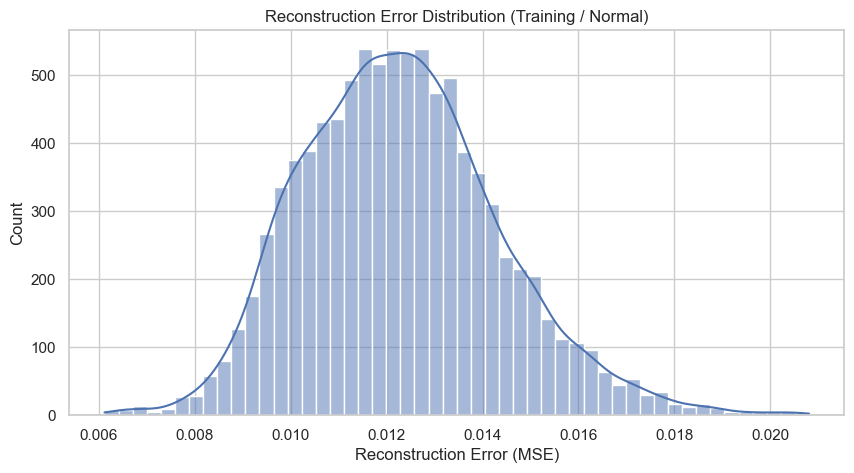

Anomaly threshold: 0.01845797769794204


In [9]:
X_train_pred = model.predict(X_train)

train_mse = np.mean(np.square(X_train_pred - X_train), axis=(1, 2))

print("Mean :", train_mse.mean())
print("Std  :", train_mse.std())
print("Max  :", train_mse.max())

plt.figure(figsize=(10,5))
sns.histplot(train_mse, bins=50, kde=True)
plt.title("Reconstruction Error Distribution (Training / Normal)")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Count")
plt.show()

THRESHOLD = train_mse.mean() + 3 * train_mse.std()
print("Anomaly threshold:", THRESHOLD)


In [14]:
FEATURES = [
    "Accelerometer1RMS",
    "Accelerometer2RMS",
    "Current",
    "Pressure",
    "Temperature",
    "Thermocouple",
    "Voltage",
    "Volume Flow RateRMS"
]


In [16]:
TIME_STEPS = 50

import joblib

In [18]:
def create_sequences(data, seq_len):
    if isinstance(data, pd.DataFrame):
        data_array = data.values
    else:
        data_array = data  

    sequences = []
    for i in range(len(data_array) - seq_len + 1):
        sequences.append(data_array[i:i+seq_len])
    return np.array(sequences)


In [20]:
fault_df = pd.read_csv(file_path, sep=";")
fault_df['datetime'] = pd.to_datetime(fault_df['datetime'])
fault_df.set_index('datetime', inplace=True)

fault_df = fault_df[FEATURES]
fault_scaled = scaler.transform(fault_df)

X_fault = create_sequences(fault_scaled, TIME_STEPS)

X_pred = model.predict(X_fault, verbose=0)
recon_error = np.mean(np.abs(X_pred - X_fault), axis=(1,2))

anomaly_ratio = (recon_error > THRESHOLD).mean()

print(f"Valve1 file {i}.csv | Anomaly ratio: {anomaly_ratio:.3f}")

Valve1 file 0.csv | Anomaly ratio: 1.000


In [22]:
SAVE_PATH = r"C:\Users\Manaswini\Downloads\anomaly"
os.makedirs(SAVE_PATH, exist_ok=True)  

fault_folders = {
    "Valve1": range(16),      # 0-15
    "Valve2": range(4),       # 0-3
    "Other": range(1, 15)     # 1-14
}

metrics_df = pd.DataFrame(columns=["Folder", "File", "Mean_Recon_Error", "Max_Recon_Error", "Anomaly_Ratio"])

for folder, file_range in fault_folders.items():
    folder_path = os.path.join(BASE_PATH, folder)
    
    for i in file_range:
        file_path = os.path.join(folder_path, f"{i}.csv")
        
        fault_df = pd.read_csv(file_path, sep=";")
        fault_df['datetime'] = pd.to_datetime(fault_df['datetime'])
        fault_df.set_index('datetime', inplace=True)
        
        fault_df = fault_df[FEATURES]
        fault_scaled = scaler.transform(fault_df)
        
        X_fault = create_sequences(fault_scaled, TIME_STEPS)
        
        X_pred = model.predict(X_fault, verbose=0)
        recon_error = np.mean(np.abs(X_pred - X_fault), axis=(1,2))
        
        # Compute metrics
        mean_error = recon_error.mean()
        max_error = recon_error.max()
        anomaly_ratio = (recon_error > THRESHOLD).mean()
        
        metrics_df = pd.concat([
            metrics_df,
            pd.DataFrame([{
                "Folder": folder,
                "File": f"{i}.csv",
                "Mean_Recon_Error": mean_error,
                "Max_Recon_Error": max_error,
                "Anomaly_Ratio": anomaly_ratio
            }])
        ], ignore_index=True)
        
        print(f"{folder} file {i}.csv | Anomaly ratio: {anomaly_ratio:.3f}")

metrics_csv_path = os.path.join(SAVE_PATH, "fault_metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"\nAll metrics saved to: {metrics_csv_path}")

model_save_path = os.path.join(SAVE_PATH, "lstm_autoencoder_model.keras")
model.save(model_save_path)
print(f"LSTM model saved to: {model_save_path}")


C:\Users\Manaswini\AppData\Local\Temp\ipykernel_8764\1236680011.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([


Valve1 file 0.csv | Anomaly ratio: 1.000
Valve1 file 1.csv | Anomaly ratio: 1.000
Valve1 file 2.csv | Anomaly ratio: 1.000
Valve1 file 3.csv | Anomaly ratio: 1.000
Valve1 file 4.csv | Anomaly ratio: 1.000
Valve1 file 5.csv | Anomaly ratio: 1.000
Valve1 file 6.csv | Anomaly ratio: 1.000
Valve1 file 7.csv | Anomaly ratio: 1.000
Valve1 file 8.csv | Anomaly ratio: 1.000
Valve1 file 9.csv | Anomaly ratio: 1.000
Valve1 file 10.csv | Anomaly ratio: 1.000
Valve1 file 11.csv | Anomaly ratio: 1.000
Valve1 file 12.csv | Anomaly ratio: 1.000
Valve1 file 13.csv | Anomaly ratio: 1.000
Valve1 file 14.csv | Anomaly ratio: 1.000
Valve1 file 15.csv | Anomaly ratio: 1.000
Valve2 file 0.csv | Anomaly ratio: 1.000
Valve2 file 1.csv | Anomaly ratio: 1.000
Valve2 file 2.csv | Anomaly ratio: 1.000
Valve2 file 3.csv | Anomaly ratio: 1.000
Other file 1.csv | Anomaly ratio: 1.000
Other file 2.csv | Anomaly ratio: 1.000
Other file 3.csv | Anomaly ratio: 1.000
Other file 4.csv | Anomaly ratio: 1.000
Other file 5.c

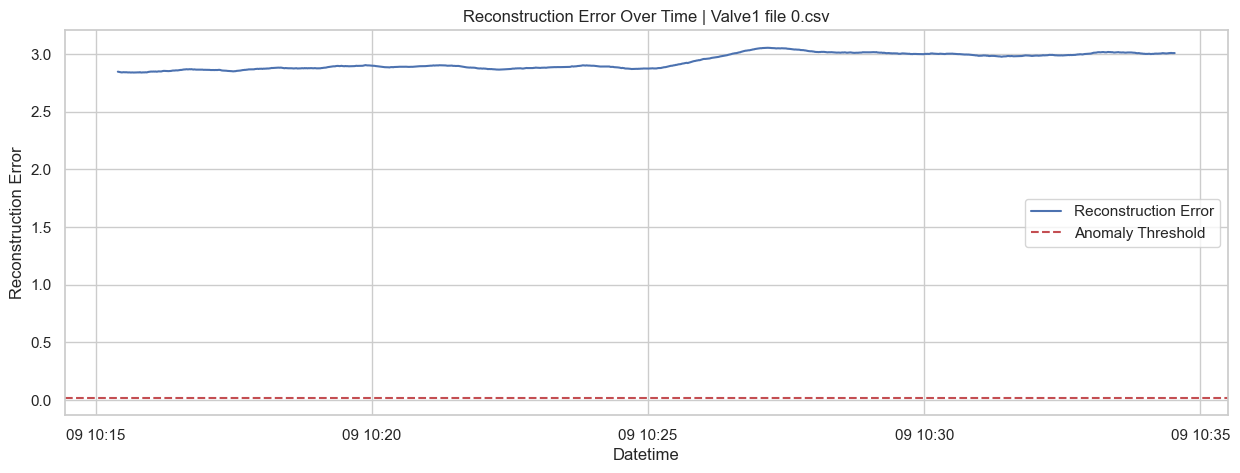

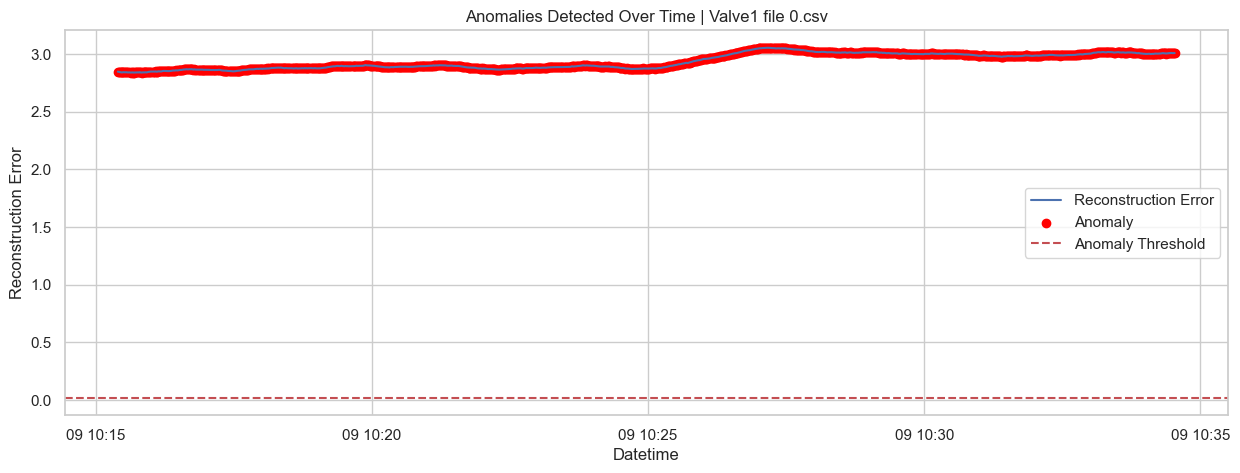

In [23]:
import matplotlib.pyplot as plt

folder = "Valve1"
file_num = 0  
file_path = os.path.join(BASE_PATH, folder, f"{file_num}.csv")

fault_df = pd.read_csv(file_path, sep=";")
fault_df['datetime'] = pd.to_datetime(fault_df['datetime'])
fault_df.set_index('datetime', inplace=True)
fault_df = fault_df[FEATURES]

fault_scaled = scaler.transform(fault_df)
X_fault = create_sequences(fault_scaled, TIME_STEPS)

X_pred = model.predict(X_fault, verbose=0)
recon_error = np.mean(np.abs(X_pred - X_fault), axis=(1,2))

time_index = fault_df.index[TIME_STEPS-1:]  
plt.figure(figsize=(15,5))
plt.plot(time_index, recon_error, label="Reconstruction Error")
plt.axhline(y=THRESHOLD, color='r', linestyle='--', label="Anomaly Threshold")
plt.title(f"Reconstruction Error Over Time | {folder} file {file_num}.csv")
plt.xlabel("Datetime")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()

anomalies = recon_error > THRESHOLD
plt.figure(figsize=(15,5))
plt.plot(time_index, recon_error, label="Reconstruction Error")
plt.scatter(time_index[anomalies], recon_error[anomalies], color='red', label='Anomaly')
plt.axhline(y=THRESHOLD, color='r', linestyle='--', label="Anomaly Threshold")
plt.title(f"Anomalies Detected Over Time | {folder} file {file_num}.csv")
plt.xlabel("Datetime")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()